In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib


from PIL import Image
import os, os.path

In [ ]:
imgs = []
path = "/content/drive/My Drive/soilClassification/SoilTypes"
textures_path = "/content/drive/My Drive/soilClassification/SoilTextures"

valid_images = [".jpg",".gif",".png",".tga"]
# for f in os.listdir(path):
#     folder_path = path+"/"+f
#     if os.path.isdir(folder_path):
#         for file in os.listdir(folder_path):
#             ext = os.path.splitext(file)[1]
#             if ext.lower() not in valid_images:
#                 continue
#             imgs.append(Image.open(os.path.join(folder_path,file)))


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds_textures = tf.keras.utils.image_dataset_from_directory(
  textures_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 156 files belonging to 5 classes.
Using 125 files for training.
Found 147 files belonging to 3 classes.
Using 118 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds_textures = tf.keras.utils.image_dataset_from_directory(
  textures_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 156 files belonging to 5 classes.
Using 31 files for validation.
Found 147 files belonging to 3 classes.
Using 29 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names_textures = train_ds_textures.class_names

print(class_names, class_names_textures)

['Black', 'Cinder', 'Laterite', 'Peat', 'Yellow'] ['Gravel', 'Sand', 'Silt']


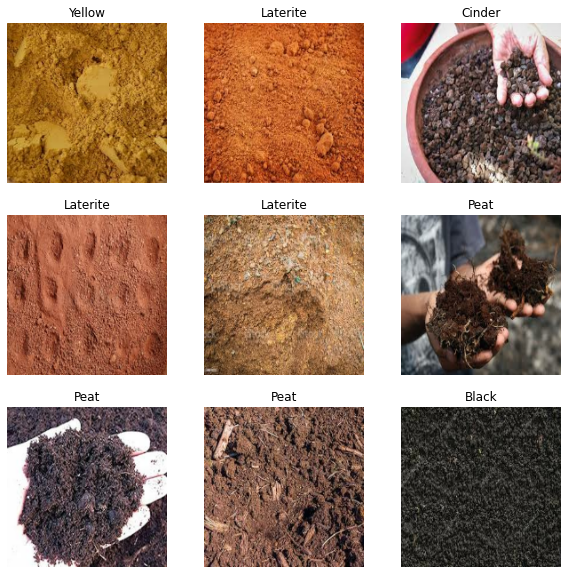

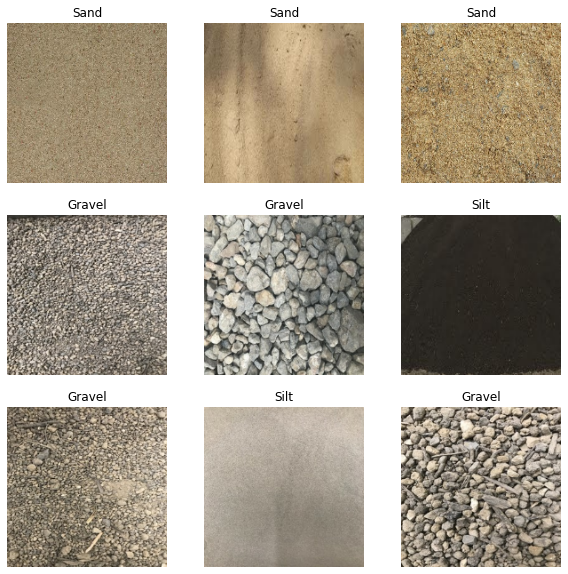

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in train_ds_textures.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_textures[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_textures = train_ds_textures.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_textures = val_ds_textures.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalization_layer_textures = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normalized_ds_textures = train_ds_textures.map(lambda x, y: (normalization_layer_textures(x), y))
image_batch_textures, labels_batch_textures = next(iter(normalized_ds_textures))
first_image_textures = image_batch_textures[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image_textures), np.max(first_image_textures))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.9822304
0.12225448 0.9873005


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

num_classes_textures = len(class_names_textures)

model_textures = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes_textures)
])

In [ ]:
model.summary()
model_textures.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/10


4/4 [==============================] - 7s 851ms/step - loss: 0.6305 - accuracy: 0.7760 - val_loss: 1.9719 - val_accuracy: 0.5484
Epoch 2/10
4/4 [==============================] - 3s 777ms/step - loss: 0.5078 - accuracy: 0.7840 - val_loss: 0.5538 - val_accuracy: 0.7419
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 0.3533 - accuracy: 0.8480 - val_loss: 0.5960 - val_accuracy: 0.8065
Epoch 4/10
4/4 [==============================] - 3s 811ms/step - loss: 0.3005 - accuracy: 0.8960 - val_loss: 0.5933 - val_accuracy: 0.8065
Epoch 5/10
4/4 [==============================] - 3s 764ms/step - loss: 0.3101 - accuracy: 0.8800 - val_loss: 0.5830 - val_accuracy: 0.7419
Epoch 6/10
4/4 [==============================] - 3s 814ms/step - loss: 0.2679 - accuracy: 0.9200 - val_loss: 0.6834 - val_accuracy: 0.7419
Epoch 7/10
4/4 [==============================] - 4s 1s/step - loss: 0.2320 - accuracy: 0.9360 - val_loss: 0.6245 - val_accuracy: 0.8065
Epoch 8/10
4/4 [=====================

In [ ]:
model_textures.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history_textures = model_textures.fit(
  train_ds_textures,
  validation_data=val_ds_textures,
  epochs=epochs
)

Epoch 1/10


4/4 [==============================] - 7s 749ms/step - loss: 0.8268 - accuracy: 0.5932 - val_loss: 3.1857 - val_accuracy: 0.3103
Epoch 2/10
4/4 [==============================] - 3s 713ms/step - loss: 0.7166 - accuracy: 0.7542 - val_loss: 1.3932 - val_accuracy: 0.5172
Epoch 3/10
4/4 [==============================] - 3s 787ms/step - loss: 0.6361 - accuracy: 0.7712 - val_loss: 2.2808 - val_accuracy: 0.3103
Epoch 4/10
4/4 [==============================] - 3s 707ms/step - loss: 0.5905 - accuracy: 0.7712 - val_loss: 1.6089 - val_accuracy: 0.5862
Epoch 5/10
4/4 [==============================] - 3s 728ms/step - loss: 0.5234 - accuracy: 0.7797 - val_loss: 1.7852 - val_accuracy: 0.5862
Epoch 6/10
4/4 [==============================] - 3s 850ms/step - loss: 0.4657 - accuracy: 0.8136 - val_loss: 2.2468 - val_accuracy: 0.5172
Epoch 7/10
4/4 [==============================] - 3s 761ms/step - loss: 0.4254 - accuracy: 0.8051 - val_loss: 1.6019 - val_accuracy: 0.5862
Epoch 8/10
4/4 [===============

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

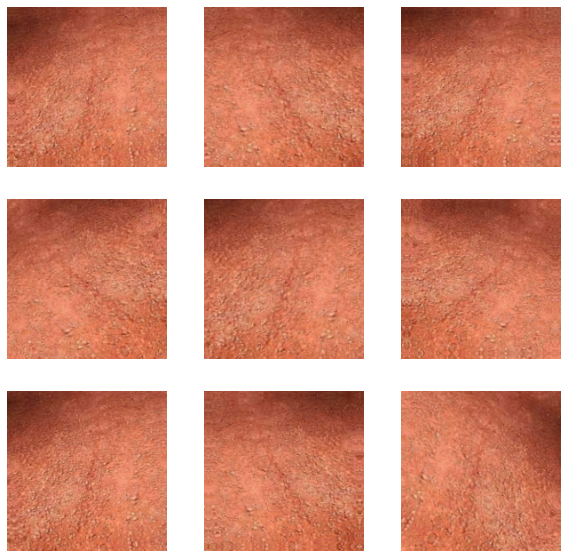

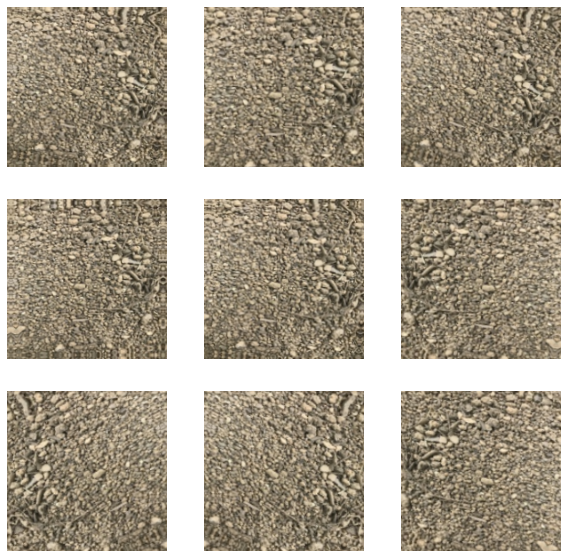

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, _ in train_ds_textures.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model_textures = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes_textures, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_textures.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()
model_textures.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

history_textures = model.fit(
  train_ds_textures,
  validation_data=val_ds_textures,
  epochs=15
)

Epoch 1/15


4/4 [==============================] - 8s 1s/step - loss: 1.7808 - accuracy: 0.2000 - val_loss: 1.6632 - val_accuracy: 0.1935
Epoch 2/15
4/4 [==============================] - 3s 759ms/step - loss: 1.5840 - accuracy: 0.2400 - val_loss: 1.4996 - val_accuracy: 0.2903
Epoch 3/15
4/4 [==============================] - 4s 983ms/step - loss: 1.4173 - accuracy: 0.4160 - val_loss: 1.3167 - val_accuracy: 0.2903
Epoch 4/15
4/4 [==============================] - 3s 745ms/step - loss: 1.1452 - accuracy: 0.5440 - val_loss: 1.0184 - val_accuracy: 0.6129
Epoch 5/15
4/4 [==============================] - 3s 813ms/step - loss: 0.9157 - accuracy: 0.6240 - val_loss: 0.9839 - val_accuracy: 0.3548
Epoch 6/15
4/4 [==============================] - 4s 956ms/step - loss: 0.7480 - accuracy: 0.7040 - val_loss: 0.7479 - val_accuracy: 0.6129
Epoch 7/15
4/4 [==============================] - 3s 762ms/step - loss: 0.6678 - accuracy: 0.6880 - val_loss: 0.8040 - val_accuracy: 0.6129
Epoch 8/15
4/4 [==================

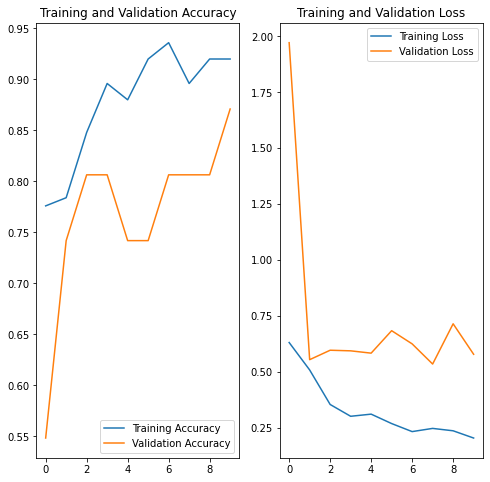

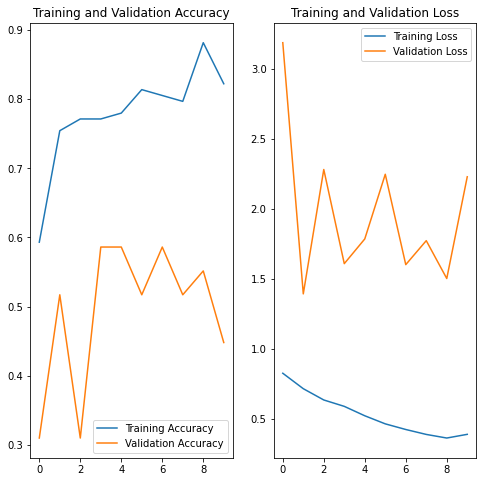

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Do the same here for textures
acc_textures = history_textures.history['accuracy']
val_acc_textures = history_textures.history['val_accuracy']

loss_textures = history_textures.history['loss']
val_loss_textures = history_textures.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_textures, label='Training Accuracy')
plt.plot(epochs_range, val_acc_textures, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_textures, label='Training Loss')
plt.plot(epochs_range, val_loss_textures, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
colors = {
  "Black": 100,
  "Peat": 70,
  "Yellow": 40,
  "Laterite": 30,
  "Cinder": 10
}


textures = {
  "Gravel": 20,
  "Sand": 40,
  "Silt": 100,
}


soil_results = []
soil_urls = ["https://www.nps.gov/articles/images/960px-mature-crust-4-austin-tumas.jpg", "https://thumbs.dreamstime.com/b/yellow-sand-dry-soil-texture-background-red-abstract-land-natural-abstraction-clay-color-ochre-construction-copy-184122739.jpg","https://previews.123rf.com/images/jes2ufoto/jes2ufoto1606/jes2ufoto160600014/60388977-black-soil-texture-with-small-plants-germinated.jpg", "https://incrediblesand.co.za/wp-content/uploads/2017/07/brown-s.jpg","https://images.thdstatic.com/productImages/36c19d7f-c2d4-4447-a733-50c93f1e6a7f/svn/topsoil-71151180-a0_600.jpg", "https://previews.123rf.com/images/mirage3/mirage31303/mirage3130300006/18234970-tropical-laterite-soil-or-red-earth-background.jpg","https://3.imimg.com/data3/VQ/MX/MY-9397880/yellow-soil-500x500.png","https://pbs.twimg.com/media/EAjNc2HU0AAdP2_.jpg","https://static.wixstatic.com/media/b0cf16_6f226331aa864024a96ef0976fe003b0~mv2.jpg/v1/fill/w_640,h_490,al_c,q_80,usm_0.66_1.00_0.01,enc_auto/b0cf16_6f226331aa864024a96ef0976fe003b0~mv2.jpg","https://images.jdmagicbox.com/rep/b2b/black-soil/black-soil-1.png","https://www.boughton.co.uk/wp-content/uploads/sites/14/2019/07/Sandy-Soil-1.jpg","https://www.greensofkerala.com/wp-content/uploads/2021/03/red-soil-1.gif"]
i = 0
for soil_url in soil_urls:
  soil_metric = 0
  path_name = 'SoilImgsFore' + str(i)
  i+=1
  soil_path = tf.keras.utils.get_file(path_name, origin=soil_url)
  img = tf.keras.utils.load_img(
      soil_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  predictions_texture = model_textures.predict(img_array)
  score_texture = tf.nn.softmax(predictions_texture[0])

  soil_metric += colors[class_names[np.argmax(score)]] / 2
  soil_metric += textures[class_names_textures[np.argmax(score_texture)]] / 2
  soil_results.append(soil_metric)
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names_textures[np.argmax(score_texture)], 100 * np.max(score_texture))
  )

print("\nSoil Health:")
print(soil_results)


1/1 [==============================] - 0s 64ms/step
This image most likely belongs to Cinder with a 98.60 percent confidence.
This image most likely belongs to Gravel with a 99.97 percent confidence.
1/1 [==============================] - 0s 48ms/step
This image most likely belongs to Yellow with a 99.73 percent confidence.
This image most likely belongs to Silt with a 96.59 percent confidence.
1/1 [==============================] - 0s 44ms/step
This image most likely belongs to Black with a 100.00 percent confidence.
This image most likely belongs to Silt with a 99.98 percent confidence.
1/1 [==============================] - 0s 105ms/step
This image most likely belongs to Black with a 100.00 percent confidence.
This image most likely belongs to Silt with a 99.98 percent confidence.
1/1 [==============================] - 0s 25ms/step
This image most likely belongs to Black with a 100.00 percent confidence.
This image most likely belongs to Silt with a 99.82 percent confidence.
1/1 [==

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Convert the model.
converter_texture = tf.lite.TFLiteConverter.from_keras_model(model_textures)
tflite_model_texture = converter_texture.convert()

# Save the model.
with open('model_textures.tflite', 'wb') as f:
  f.write(tflite_model_texture)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

TF_MODEL_FILE_PATH_TEXTURE = 'model_textures.tflite' # The default path to the saved TensorFlow Lite model

interpreter_texture = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH_TEXTURE)

In [ ]:
interpreter.get_signature_list()
interpreter_texture.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

classify_lite_texture = interpreter_texture.get_signature_runner('serving_default')
classify_lite_texture

In [ ]:
predictions_lite = classify_lite(sequential_2_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

predictions_lite_texture = classify_lite_texture(sequential_2_input=img_array)['outputs']
score_lite_texture = tf.nn.softmax(predictions_lite_texture)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names_textures[np.argmax(score_lite)], 100 * np.max(score_lite))
)


This image most likely belongs to Laterite with a 96.07 percent confidence.
This image most likely belongs to Silt with a 96.07 percent confidence.


In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))
print(np.max(np.abs(predictions_texture - predictions_lite_texture)))

1.9073486e-06
2.4214387e-07
